In [2]:
pip install spacy

  Attempting uninstall: smart-open
    Found existing installation: smart-open 5.1.0
    Uninstalling smart-open-5.1.0:
      Successfully uninstalled smart-open-5.1.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import pkg_resources


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)

from typing import List, Callable, Dict, Tuple, Set

In [5]:
#Needs to be installed on Colab as well
!python -m spacy download en_core_web_lg -q

nlp = spacy.load('en_core_web_lg')

# Only run this once, they will be downloaded.
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('omw-1.4',quiet=True)

2022-11-20 15:03:33.131317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-11-20 15:03:33.131379: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-20 15:03:37.005878: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-11-20 15:03:37.005914: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 15:03:37.011179: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-BDR6HDN0
2022-11-20 15:03:37.011316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-BDR6HDN0


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


2022-11-20 15:03:52.869670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-11-20 15:03:52.869717: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-20 15:03:57.382597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'nvcuda.dll'; dlerror: nvcuda.dll not found
2022-11-20 15:03:57.382630: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 15:03:57.386284: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LAPTOP-BDR6HDN0
2022-11-20 15:03:57.386376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LAPTOP-BDR6HDN0


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


True

In [6]:
#Gotta love the functions

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

#Knowledge Context Graph Functions

def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(kg_df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

In [7]:
# Entity Extraction Functions
# More useful info found here:
# https://hami-asmai.medium.com/relationship-extraction-from-any-web-articles-using-spacy-and-jupyter-notebook-in-6-steps-4444ee68763f

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

In [8]:
#Visualization Utility Functions

def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [33]:
# Let's read in the dataset
v_df = pd.read_csv(r'youtube_links_with_metadatav2.0.csv')

v_df.head()

,Unnamed: 0,link,title,author,publish_date,Subscribers,views,length_seconds,rating,transcript
0,0,https://youtu.be/0JE-VbmzQzo,How to Change a Car Battery | DIY Car Repairs ...,The Home Depot,2020-07-08,507000,443252,140,NaN,"[, Music ], knowing how to change a car batter..."
1,1,https://youtu.be/OQGLZxPcd-o,How to change Car battery SAFELY - Which wire ...,Frakking Creations,2020-01-23,11400,273373,382,NaN,If your car has a battery that needs replacing...
2,2,https://youtu.be/79aMfc-SxzE,How To Replace Your Car Battery,Family Handyman,2020-11-20,127000,3793,105,NaN,"Hi, i'm joe with family handyman. You need to ..."
3,3,https://youtu.be/auhfI1zWBco,How To: Install a Battery in Your Vehicle,O'Reilly Auto Parts,2018-01-29,128000,856665,172,NaN,"[ Mechnical SFX ], Hey everybody, John here wi..."
4,4,https://youtu.be/gohJtZq54rU,How to change a car battery | carsales,carsales.com.au,2017-02-22,48100,21750,122,NaN,So your car has been getting harder and harder...


In [34]:
# From our experience, let's jettison the nonstandard characters right away
v_df['transcript'] = v_df['transcript'].apply(lambda x: ''.join([i if 32 < ord(i) < 126 else " " for i in x]))

# And let's tokenize the sentences
v_df['raw_sentences'] = v_df.transcript.apply(get_sentences)
v_df.head(3).T

,0,1,2
Unnamed: 0,0,1,2
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery
author,The Home Depot,Frakking Creations,Family Handyman
publish_date,2020-07-08,2020-01-23,2020-11-20
Subscribers,507000,11400,127000
views,443252,273373,3793
length_seconds,140,382,105
rating,NaN,NaN,NaN
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ..."


In [35]:
#Let's get granular! Tokenize words engage. Plus, let's define some stopwords.

default_stopwords=\
set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({'', ''})
v_df['lemmas'] = v_df.transcript.apply(lambda x: get_lemmas(x, default_stopwords))
v_df.lemmas.head()

0    [music, know, change, car, battery, save, expe...
1    [car, battery, need, replace, want, want, sure...
2    [hi, joe, family, handyman, need, replace, car...
3    [mechnical, sfx, hey, everybody, john, oreilly...
4    [car, hard, hard, start, morning, come, comple...
Name: lemmas, dtype: object

In [36]:
# Lemmatized words... assemble!

v_df['lemmas_joined'] = v_df.lemmas.apply(lambda x: ' '.join(x))
v_df.head(3).T

,0,1,2
Unnamed: 0,0,1,2
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery
author,The Home Depot,Frakking Creations,Family Handyman
publish_date,2020-07-08,2020-01-23,2020-11-20
Subscribers,507000,11400,127000
views,443252,273373,3793
length_seconds,140,382,105
rating,NaN,NaN,NaN
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ..."


In [37]:
#Vocabulary data wrangling

vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(v_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=v_df.author)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

# Research opportunity: ignore terms that aren't within these frequencies... change the frequencies
vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(v_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=v_df.author)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 1625
Curated Vocabulary size: 267


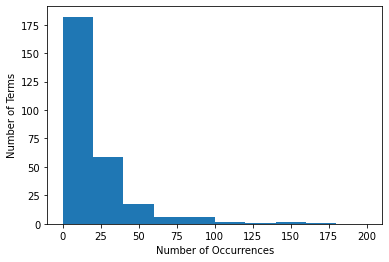

In [18]:
#Let's take a look at this in bar graph form

plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences')
plt.ylabel('Number of Terms');

In [38]:
# Re-tokenize words, recreate joined documents
v_df['lemmas'] = v_df.transcript.apply(lambda x: get_lemmas(x, words_to_remove))
v_df['lemmas_joined'] = v_df.lemmas.apply(lambda x: ' '.join(x))

# And get the lemmatized and filtered sentences
v_df['sentences_lemmatized']=\
v_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

v_df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE,https://youtu.be/auhfI1zWBco,https://youtu.be/gohJtZq54rU
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery,How To: Install a Battery in Your Vehicle,How to change a car battery | carsales
author,The Home Depot,Frakking Creations,Family Handyman,O'Reilly Auto Parts,carsales.com.au
publish_date,2020-07-08,2020-01-23,2020-11-20,2018-01-29,2017-02-22
Subscribers,507000,11400,127000,128000,48100
views,443252,273373,3793,856665,21750
length_seconds,140,382,105,172,122
rating,NaN,NaN,NaN,NaN,NaN
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ...","[ Mechnical SFX ], Hey everybody, John here wi...",So your car has been getting harder and harder...


In [39]:
#Lines of code to look at both raw sentences and lemmatized sentences.

#corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
corpus_text_sentences = [y for x in v_df.sentences_lemmatized for y in x]
example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

'plus sign red plastic cover glove use wrench loosen nut black cable set aside away loosen nut end cable ahead clamp bracket secure set aside ready carefully tray use wire brush tray connector'

In [40]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]
entity_pairs

100%|██████████| 1616/1616 [00:14<00:00, 108.59it/s]


[['music', 'know shop'],
 ['long safety change', ''],
 ['', ''],
 ['key pop vehicle engine', 'key pop vehicle hood'],
 ['', 'black minus sign cable'],
 ['', 'carefully brush tray connector'],
 ['', 'cable black cable cover'],
 ['post', 'secure cable cable'],
 ['close test connection instal', 'automotive know thank'],
 ['replace', 'sure owner manual'],
 ['', 'trunk hood'],
 ['', 'vehicle memory saver'],
 ['preset  vehicle', 'old security code power'],
 ['', 'memory'],
 ['saver channel', 'subscribe channel check'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['ground', 'connect  metal'],
 ['', ''],
 ['', ''],
 ['connect', 'metal cause short'],
 ['', 'short check manual'],
 ['typically millimeter socket', 'correct  cable'],
 ['', 'short  happen'],
 ['', ''],
 ['cable way', 'way touch step bracket'],
 ['', 'sure drop engine'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['right acid step', 'sure hold place'],
 ['', ''],
 ['clean  brush', ''],
 ['grease corrosion step', 'revers

In [104]:
#Creates the dataframe for the source, target, and edge properties of the knowledge graph

relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [105]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

kg_df.tail(6).T

,1535,1546,1571,1574,1608,1613
source,secure hold clamp,type people,pop,okay old,bracket,clamp
target,tighten cable,pretty turn reason change,right music,correct position,little hook hook,little hole tray
edge,attach,wait,let,attach correct,hold,hook little


In [42]:
len(corpus_text_sentences)

1616

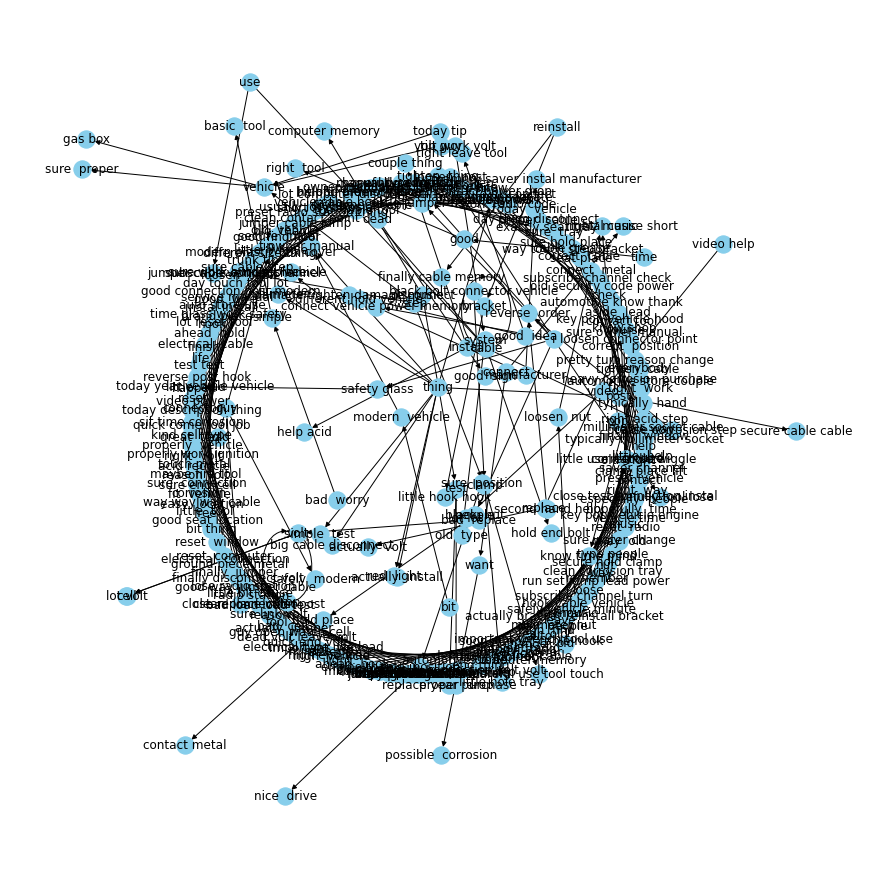

In [106]:
# Let's visualize ourselves a fancy knowledge graph

plot_graph(kg_df, use_circular=False)

In [107]:
#Let's take a look at the top sources and targets for the lemmatized sentences

get_top_sources_and_targets(kg_df, 25)

[('thing', 9),
 ('i', 7),
 ('cable', 6),
 ('vehicle', 5),
 ('clamp', 4),
 ('step', 3),
 ('volt', 3),
 ('test', 3),
 ('old', 3),
 ('post', 2),
 ('replace', 2),
 ('connect', 2),
 ('loosen  nut', 2),
 ('everybody', 2),
 ('manufacturer', 2),
 ('good  idea', 2),
 ('reinstall', 2),
 ('install', 2),
 ('disconnect', 2),
 ('dead', 2),
 ('good', 2),
 ('simple', 2),
 ('use', 2),
 ('modern  vehicle', 2),
 ('guy', 2)]

In [109]:
#Can't forget about the edges

get_top_edges(kg_df, 25)

[('want', 10),
 ('let', 9),
 ('use', 7),
 ('come', 5),
 ('lose', 5),
 ('tell', 5),
 ('replace', 5),
 ('watch', 4),
 ('remember', 4),
 ('leave', 4),
 ('hold', 4),
 ('allow', 3),
 ('attach', 3),
 ('install', 3),
 ('try', 3),
 ('undo', 3),
 ('help', 3),
 ('know', 3),
 ('want sure', 3),
 ('disconnect', 3),
 ('find', 2),
 ('lead', 2),
 ('ve', 2),
 ('stop', 2),
 ('connect', 2)]

<AxesSubplot:xlabel='views', ylabel='Subscribers'>

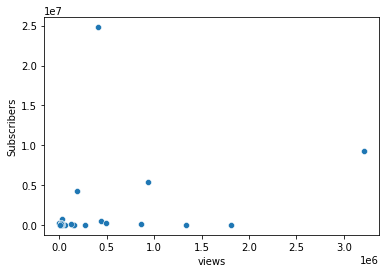

In [102]:
sns.scatterplot(data = v_df, x = "views", y = "Subscribers")

In [95]:
v_df['Reach'] = v_df['views']/v_df['Subscribers']
v_df.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Unnamed: 0,0,1,2,3,4,5,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE,https://youtu.be/auhfI1zWBco,https://youtu.be/gohJtZq54rU,https://youtu.be/JHo9RG0FXwQ,https://youtu.be/EWuz7GpeYqQ,https://youtu.be/N4uJIbPb8yU,https://youtu.be/lqd-A6bteqw,https://youtu.be/XN4GSRObmBA,...,https://youtu.be/O2wTgnIwuVM,https://youtu.be/1CSiwhWblkc,https://youtu.be/6waai8__cRA,https://youtu.be/xoTI43qt3KU,https://youtu.be/ItDwvHDf094,https://youtu.be/R7IFYjXjScM,https://youtu.be/nbFZCwuN5R4,https://youtu.be/MFCQCRd8Pe8,https://youtu.be/5I-98spEccU,https://youtu.be/uHieGuMrR60
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery,How To: Install a Battery in Your Vehicle,How to change a car battery | carsales,How to Replace a Car Battery Like a Pro,How to change a car battery,How to Replace a Car Battery | Mitre 10 Easy A...,How to Change Your Car Battery,How to Replace a Car Battery (the Right Way),...,How to change a car battery without loosing me...,how to replace your car battery without damag...,How To Test & Replace A Car Battery - COSTCO v...,How To Change A Car Battery,How to Change a Car Battery and not Lose the R...,PawPaw Shows the Right Way to Change a Car Bat...,How to Replace Your Vehicle's Battery (Toyota ...,How to Change a Car Battery,How to Change and Replace a Car Battery | Opel...,1998-2008 Toyota Corolla Battery remove and in...
author,The Home Depot,Frakking Creations,Family Handyman,O'Reilly Auto Parts,carsales.com.au,Interstate Batteries,Repco,Mitre 10 New Zealand,AutoZone,Scotty Kilmer,...,Ryan,NATES INTERACTIVE AUTO,dial2fast,Silverline Tools,DIY Home and Gardening,DoingItCheap,Galipp's Gadgets,WatchMojo.com,Mikko & Charlie,NutzAboutBolts
publish_date,2020-07-08,2020-01-23,2020-11-20,2018-01-29,2017-02-22,2021-08-19,2018-05-18,2018-07-05,2022-02-08,2018-02-02,...,2018-12-04,2019-08-09,2021-03-09,2015-12-09,2020-06-27,2018-02-25,2014-07-22,2008-04-02,2020-10-15,2014-08-14
Subscribers,507000,11400,127000,128000,48100,5810,2490,251000,148000,5390000,...,2080,81600,192000,191000,4260,88100,1480,24800000,125,71600
views,443252,273373,3793,856665,21750,59330,30750,495584,3601,937891,...,146280,22294,16572,18168,13838,19522,152824,405017,1612,117905
length_seconds,140,382,105,172,122,224,263,281,282,197,...,522,240,652,396,618,601,551,110,546,142
rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ...","[ Mechnical SFX ], Hey everybody, John here wi...",So your car has been getting harder and harder...,"[, Music ], Hey there If you're watching this ...",This car is taking an unusual amount of time t...,"If your car's cranking, slowly or not at all, ...","You sound good mike, and i call you mike techn...","Rev up your engines today, I'm going to show y...",...,I'M gon na show you guys how to quickly easily...,"Before changing your battery, you definitely n...",Hello viewers - this is not too fast here this...,Hi there I'm Midge and I have been modifiying ...,"When everyone Cmdr, why hymen gardening differ...","Well, how y'all doing it's pop again one thing...","Everybody today, I'm going to show you how to ...","Hello, this is Chris with watchmojo.com. Now, ...",And a one and a two and [ Music ] welcome to m...,"Okay, right now we're going to remove our batt..."


[None]

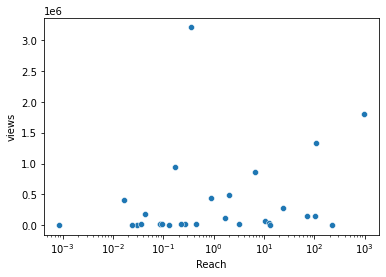

In [94]:
test = sns.scatterplot(data = v_df, x = "Reach", y = "views" )
test.set(xscale="log")

#find line of best fit
#a, b = np.polyfit(v_df["Reach"], v_df["views"], 1)

#add line of best fit to plot
#plt.plot(v_df["Reach"], a*v_df["Reach"]+b)

In [55]:
v_df['Rating'] = pd.qcut(v_df['Reach'], q=5)


v_df['Rating'] = v_df['Rating'].astype("category")
v_df['Rating'] = v_df['Rating'].cat.codes
#v_df['Genre of Movie code'].tail().T

v_df['key'] = v_df['link'].str.split('be/').str[-1]
v_df.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
Unnamed: 0,0,1,2,3,4,5,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
link,https://youtu.be/0JE-VbmzQzo,https://youtu.be/OQGLZxPcd-o,https://youtu.be/79aMfc-SxzE,https://youtu.be/auhfI1zWBco,https://youtu.be/gohJtZq54rU,https://youtu.be/JHo9RG0FXwQ,https://youtu.be/EWuz7GpeYqQ,https://youtu.be/N4uJIbPb8yU,https://youtu.be/lqd-A6bteqw,https://youtu.be/XN4GSRObmBA,...,https://youtu.be/O2wTgnIwuVM,https://youtu.be/1CSiwhWblkc,https://youtu.be/6waai8__cRA,https://youtu.be/xoTI43qt3KU,https://youtu.be/ItDwvHDf094,https://youtu.be/R7IFYjXjScM,https://youtu.be/nbFZCwuN5R4,https://youtu.be/MFCQCRd8Pe8,https://youtu.be/5I-98spEccU,https://youtu.be/uHieGuMrR60
title,How to Change a Car Battery | DIY Car Repairs ...,How to change Car battery SAFELY - Which wire ...,How To Replace Your Car Battery,How To: Install a Battery in Your Vehicle,How to change a car battery | carsales,How to Replace a Car Battery Like a Pro,How to change a car battery,How to Replace a Car Battery | Mitre 10 Easy A...,How to Change Your Car Battery,How to Replace a Car Battery (the Right Way),...,How to change a car battery without loosing me...,how to replace your car battery without damag...,How To Test & Replace A Car Battery - COSTCO v...,How To Change A Car Battery,How to Change a Car Battery and not Lose the R...,PawPaw Shows the Right Way to Change a Car Bat...,How to Replace Your Vehicle's Battery (Toyota ...,How to Change a Car Battery,How to Change and Replace a Car Battery | Opel...,1998-2008 Toyota Corolla Battery remove and in...
author,The Home Depot,Frakking Creations,Family Handyman,O'Reilly Auto Parts,carsales.com.au,Interstate Batteries,Repco,Mitre 10 New Zealand,AutoZone,Scotty Kilmer,...,Ryan,NATES INTERACTIVE AUTO,dial2fast,Silverline Tools,DIY Home and Gardening,DoingItCheap,Galipp's Gadgets,WatchMojo.com,Mikko & Charlie,NutzAboutBolts
publish_date,2020-07-08,2020-01-23,2020-11-20,2018-01-29,2017-02-22,2021-08-19,2018-05-18,2018-07-05,2022-02-08,2018-02-02,...,2018-12-04,2019-08-09,2021-03-09,2015-12-09,2020-06-27,2018-02-25,2014-07-22,2008-04-02,2020-10-15,2014-08-14
Subscribers,507000,11400,127000,128000,48100,5810,2490,251000,148000,5390000,...,2080,81600,192000,191000,4260,88100,1480,24800000,125,71600
views,443252,273373,3793,856665,21750,59330,30750,495584,3601,937891,...,146280,22294,16572,18168,13838,19522,152824,405017,1612,117905
length_seconds,140,382,105,172,122,224,263,281,282,197,...,522,240,652,396,618,601,551,110,546,142
rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transcript,"[, Music ], knowing how to change a car batter...",If your car has a battery that needs replacing...,"Hi, i'm joe with family handyman. You need to ...","[ Mechnical SFX ], Hey everybody, John here wi...",So your car has been getting harder and harder...,"[, Music ], Hey there If you're watching this ...",This car is taking an unusual amount of time t...,"If your car's cranking, slowly or not at all, ...","You sound good mike, and i call you mike techn...","Rev up your engines today, I'm going to show y...",...,I'M gon na show you guys how to quickly easily...,"Before changing your battery, you definitely n...",Hello viewers - this is not too fast here this...,Hi there I'm Midge and I have been modifiying ...,"When everyone Cmdr, why hymen gardening differ...","Well, how y'all doing it's pop again one thing...","Everybody today, I'm going to show you how to ...","Hello, this is Chris with watchmojo.com. Now, ...",And a one and a two and [ Music ] welcome to m...,"Okay, right now we're going to remove our batt..."


In [56]:
v_df['Rating'].value_counts()

4    6
0    6
3    6
1    6
2    5
Name: Rating, dtype: int64

In [81]:
# Whoa, that's kinda messy... Maybe this will make sense when we develop the RNN model

datafull=v_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head().T

#Let's do a little data preprocessing.

datafull['transcript'] = datafull['transcript'].apply(lambda x :clean_doc(x))

freshdf = datafull[['transcript','Rating']].copy()

freshdf['Rating'] = freshdf['Rating'].astype("category")
freshdf['Rating'] = freshdf['Rating'].cat.codes
freshdf['Rating'].tail().T

24    1
25    4
26    0
27    3
28    2
Name: Rating, dtype: int8

In [82]:
features, targets = freshdf['transcript'], freshdf['Rating']
 
train_features, test_features, train_targets, test_targets = train_test_split(features
                                                                              ,targets
                                                                              ,test_size=0.33
                                                                              ,random_state=22
                                                                              ,shuffle = True
                                                                              ,stratify=targets)

In [83]:
# Let's create the training and testing datasets

trainds, valds, testds = get_dataset_partitions_pd(freshdf[['transcript','Rating']])
trainds.shape, valds.shape, testds.shape

((23, 2), (3, 2), (3, 2))

In [84]:
#And convert from dataframe to Tensorflow dataset

# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['transcript'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Rating'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['transcript'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Rating'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['transcript'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Rating'].values, tf.int64),
)

#Create DataSets (X=Preprocessed Text, Y=Encoded Categories)

train_ds = tf.data.Dataset.zip(
    (
            train_text_ds_raw,
            train_cat_ds_raw
     )
)
test_ds = tf.data.Dataset.zip(
    (
            test_text_ds_raw,
            test_cat_ds_raw
     )
)
val_ds = tf.data.Dataset.zip(
    (
            val_text_ds_raw,
            val_cat_ds_raw
     )
)

# Create Data Pipelines (Batching, Shuffling, and Optimizing)

batch_size = 2 #Research change parameter from 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds.cardinality().numpy()

train_ds = train_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds = test_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


val_ds = val_ds.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)


freshdf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   transcript  29 non-null     object
 1   Rating      29 non-null     int8  
dtypes: int8(1), object(1)
memory usage: 389.0+ bytes


In [85]:
# For more information: tf.keras.layers.TextVectorization
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

VOCAB_SIZE= 2000 # Research experiment to see if adjusting vocab size can improve the model
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder.adapt(train_ds.map(lambda text, label: text), batch_size= None)

vocab = np.array(encoder.get_vocabulary())
len(vocab)

1837

In [71]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'battery', 's', 'car', 'nt', 're', 'terminal', 'i',
       'get', 'so', 'make', 'going', 'sure', 'positive', 'go', 'one',
       'negative', 'right', 'remove'], dtype='<U18')

In [96]:
# Building the RNN sequential model

num_classes=5 # Changed from 5 as we only have 4 genres
model=tf.keras.Sequential([encoder
   ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 96, mask_zero=True)
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96,  return_sequences=True, dropout=0.4))
   ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,dropout=0.4))
   ,tf.keras.layers.Dense(24, activation='relu')
   ,tf.keras.layers.Dense(num_classes,activation='softmax')  
])

In [97]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 96)          176352    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 192)        148224    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              131584    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                3096      
                                                      

In [98]:
# Compiling the model

model.compile(optimizer= tf.keras.optimizers.Adam( )
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
              ,metrics=['accuracy'])

In [99]:
%%time
history = model.fit(train_ds
         ,steps_per_epoch=int(23/batch_size)           
         ,epochs=20
         ,validation_data=val_ds
         ,validation_steps=int(3/batch_size)
         ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/20
11/11 [==============================] - 70s 3s/step - loss: 1.6185 - accuracy: 0.0909 - val_loss: 1.6442 - val_accuracy: 0.0000e+00
Epoch 2/20
11/11 [==============================] - 18s 2s/step - loss: 1.5852 - accuracy: 0.4091 - val_loss: 1.7364 - val_accuracy: 0.0000e+00
Epoch 3/20
11/11 [==============================] - 18s 2s/step - loss: 1.5231 - accuracy: 0.2727 - val_loss: 1.9712 - val_accuracy: 0.0000e+00
CPU times: total: 5min 2s
Wall time: 1min 45s


In [100]:
# So, uh, how'd we do?

test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

1/1 [==============================] - 1s 869ms/step - loss: 1.9712 - accuracy: 0.0000e+00
Test Loss: 1.9712345600128174
Test Accuracy: 0.0
